In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm import tqdm
import pandas as pd

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld
from model.RNN import LSTM_representation, LSTM_GenText
from inter.simpleInteraction import simpleInteraction as inter
from outil import *

In [2]:
def get_data(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

def get_data_without_fell_front(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        all_action:list = env.get_actions()
        all_action.remove("feel_front")
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


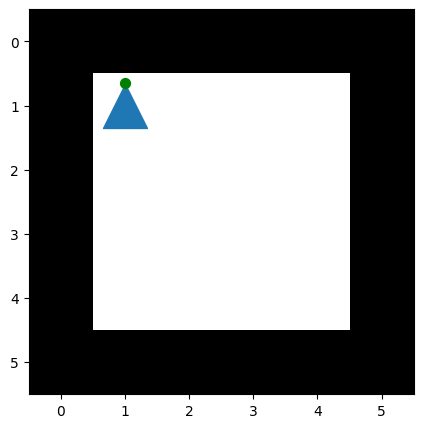

In [3]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()

In [4]:
list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    list_vocab.append(act)
for fb in env_test.get_outcomes():
    list_vocab.append(fb)

for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

<pad>
forward
turn_left
turn_right
feel_front
feel_left
feel_right
wall
empty
{'<pad>': 0, 'forward': 1, 'turn_left': 2, 'turn_right': 3, 'feel_front': 4, 'feel_left': 5, 'feel_right': 6, 'wall': 7, 'empty': 8}


# X and Y
Sur un exemple simple avec 10 actions sur un environment nous avons :

In [5]:
data_brut_y = get_data(env_test, tokenizer, n_episodes=10)
print("data_train", data_brut_y)
data_y = torch.tensor(data_brut_y)
data_y = data_y.unsqueeze(0)


data_train [3, 8, 6, 8, 5, 7, 5, 7, 6, 8, 2, 8, 2, 8, 5, 8, 6, 7, 5, 8]


In [6]:
data_brut_y = [data_brut_y]

In [7]:
data_brut_y= []
for i in range(750):
    data_brut_y.append(get_data(env_test, tokenizer, n_episodes=100))

data_y = torch.tensor(data_brut_y)

data_y est alors notre Y. Pour obtenir notre X, nous utiliserons un token Dropen

In [8]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [9]:
td = TokenDrop(0.15, pad_token=0, num_special=2)
data_x = td(data_y)
print("data_x", data_x)

data_x tensor([[3, 8, 5,  ..., 7, 6, 7],
        [5, 0, 5,  ..., 8, 3, 8],
        [4, 8, 2,  ..., 8, 2, 8],
        ...,
        [0, 7, 4,  ..., 7, 0, 0],
        [5, 8, 5,  ..., 0, 3, 8],
        [1, 8, 2,  ..., 7, 1, 0]])


Notre x est donc data_x. Maintenant nous voulons que notre model arrive à obvenir un représentation de la séquence pour réussir a compléter les 0.

# Multi tasks ?
On peut vouloir un encoder qui apprend a encoder pour deviner les actions, et un encoder qui apprends a deviner les observations.


In [10]:
class TokenDropEven(nn.Module):
    """For a batch of tokens indices, randomly replace a non-special token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        super().__init__()
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        """Mask only action (even if it is not a special token) for a batch of samples."""
        sample_out = torch.empty_like(sample)
        for i, single_sample in enumerate(sample):
            even_sample = single_sample[::2]
            odd_sample = single_sample[1::2]
            
            # Generate mask for even elements
            mask = torch.bernoulli(self.prob * torch.ones_like(even_sample)).long()
            can_drop = (even_sample >= self.num_special).long()
            mask = mask * can_drop
            
            # Replace masked elements with <pad>
            replace_with = (self.pad_token * torch.ones_like(even_sample)).long()
            even_sample_out = (1 - mask) * even_sample + mask * replace_with
            
            # Recombine even and odd elements
            sample_out[i, ::2] = even_sample_out
            sample_out[i, 1::2] = odd_sample
        
        return sample_out

In [11]:
td = TokenDropEven(0.9, pad_token=0, num_special=2)
data_x = td(data_y)
print("data_x", data_x)
print("data_y", data_y)

data_x tensor([[0, 8, 0,  ..., 7, 0, 7],
        [0, 8, 0,  ..., 8, 3, 8],
        [0, 8, 0,  ..., 8, 0, 8],
        ...,
        [0, 7, 0,  ..., 7, 0, 8],
        [0, 8, 0,  ..., 8, 0, 8],
        [1, 8, 0,  ..., 7, 1, 7]])
data_y tensor([[3, 8, 5,  ..., 7, 6, 7],
        [5, 8, 5,  ..., 8, 3, 8],
        [4, 8, 2,  ..., 8, 2, 8],
        ...,
        [4, 7, 4,  ..., 7, 2, 8],
        [5, 8, 5,  ..., 8, 3, 8],
        [1, 8, 2,  ..., 7, 1, 7]])


In [12]:
class TokenDropOdd(nn.Module):
    """For a batch of tokens indices, randomly replace a non-special token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        super().__init__()
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        """Mask only action (even if it is not a special token) for a batch of samples."""
        sample_out = torch.empty_like(sample)
        for i, single_sample in enumerate(sample):
            even_sample = single_sample[::2]
            odd_sample = single_sample[1::2]
            
            # Generate mask for even elements
            mask = torch.bernoulli(self.prob * torch.ones_like(odd_sample)).long()
            can_drop = (odd_sample >= self.num_special).long()
            mask = mask * can_drop
            
            # Replace masked elements with <pad>
            replace_with = (self.pad_token * torch.ones_like(odd_sample)).long()
            old_sample_out = (1 - mask) * odd_sample + mask * replace_with
            
            # Recombine even and odd elements
            sample_out[i, ::2] = even_sample 
            sample_out[i, 1::2] = old_sample_out
        
        return sample_out

In [13]:
td = TokenDropOdd(0.9, pad_token=0, num_special=2)
data_x = td(data_y)
print("data_x", data_x)
print("data_y", data_y)

data_x tensor([[3, 0, 5,  ..., 0, 6, 7],
        [5, 0, 5,  ..., 0, 3, 0],
        [4, 0, 2,  ..., 0, 2, 0],
        ...,
        [4, 0, 4,  ..., 0, 2, 0],
        [5, 0, 5,  ..., 0, 3, 0],
        [1, 0, 2,  ..., 0, 1, 0]])
data_y tensor([[3, 8, 5,  ..., 7, 6, 7],
        [5, 8, 5,  ..., 8, 3, 8],
        [4, 8, 2,  ..., 8, 2, 8],
        ...,
        [4, 7, 4,  ..., 7, 2, 8],
        [5, 8, 5,  ..., 8, 3, 8],
        [1, 8, 2,  ..., 7, 1, 7]])


In [14]:
class CustomDataSet(Dataset):
    def __init__(self, data:list[list]):
        self.data = torch.tensor(data)
        print(self.data)

    def __len__(self):
        return self.data.size()[1]

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
data_set = CustomDataSet(data_brut_y)

print("len data_set", data_set.__len__())
print("data_set 1", data_set[0])

tensor([[3, 8, 5,  ..., 7, 6, 7],
        [5, 8, 5,  ..., 8, 3, 8],
        [4, 8, 2,  ..., 8, 2, 8],
        ...,
        [4, 7, 4,  ..., 7, 2, 8],
        [5, 8, 5,  ..., 8, 3, 8],
        [1, 8, 2,  ..., 7, 1, 7]])
len data_set 200
data_set 1 tensor([3, 8, 5, 7, 3, 8, 2, 8, 1, 7, 2, 8, 3, 8, 2, 8, 2, 8, 3, 8, 6, 7, 3, 8,
        4, 7, 6, 8, 4, 7, 2, 8, 4, 7, 5, 8, 2, 8, 5, 8, 5, 8, 6, 7, 1, 8, 1, 8,
        1, 8, 4, 7, 6, 7, 6, 7, 2, 8, 2, 8, 6, 8, 2, 8, 5, 7, 6, 8, 1, 7, 6, 8,
        6, 8, 1, 7, 6, 8, 2, 8, 4, 7, 4, 7, 4, 7, 3, 8, 6, 8, 4, 7, 4, 7, 2, 8,
        1, 7, 3, 8, 3, 8, 4, 8, 6, 8, 5, 7, 5, 7, 2, 8, 6, 8, 2, 8, 1, 7, 2, 8,
        4, 8, 4, 8, 1, 8, 2, 8, 5, 8, 5, 8, 2, 8, 3, 8, 5, 8, 2, 8, 3, 8, 3, 8,
        2, 8, 2, 8, 4, 8, 1, 8, 3, 8, 3, 8, 5, 8, 1, 8, 2, 8, 4, 8, 6, 8, 1, 8,
        1, 8, 3, 8, 5, 8, 4, 8, 2, 8, 1, 8, 4, 7, 4, 7, 4, 7, 3, 8, 1, 8, 1, 8,
        2, 8, 6, 7, 6, 7, 6, 7])


In [16]:
data_loader = DataLoader(data_y, batch_size=2, shuffle=True)

In [17]:
for i, data in enumerate(data_loader):
    print("batch", i)
    print(data)
    data_x = td(data)
    print("data_x", data_x)

print(data_y)

batch 0
tensor([[5, 8, 6, 7, 3, 8, 5, 8, 4, 7, 3, 8, 3, 8, 6, 8, 3, 8, 6, 7, 3, 8, 6, 8,
         4, 7, 5, 8, 4, 7, 6, 8, 1, 7, 2, 8, 4, 8, 1, 8, 5, 8, 3, 8, 3, 8, 5, 7,
         2, 8, 3, 8, 4, 8, 2, 8, 6, 8, 2, 8, 3, 8, 3, 8, 5, 7, 2, 8, 1, 7, 1, 7,
         3, 8, 3, 8, 2, 8, 6, 8, 2, 8, 4, 7, 5, 7, 5, 7, 4, 7, 2, 8, 2, 8, 4, 8,
         3, 8, 1, 7, 3, 8, 6, 8, 6, 8, 5, 7, 6, 8, 1, 7, 1, 7, 6, 8, 5, 7, 3, 8,
         5, 7, 5, 7, 6, 8, 1, 8, 2, 8, 2, 8, 5, 8, 6, 7, 4, 8, 1, 8, 1, 7, 6, 7,
         1, 7, 2, 8, 1, 8, 6, 7, 3, 8, 6, 8, 1, 7, 4, 7, 6, 8, 4, 7, 2, 8, 2, 8,
         3, 8, 4, 8, 2, 8, 1, 8, 1, 8, 6, 8, 5, 8, 3, 8, 2, 8, 4, 8, 4, 8, 3, 8,
         5, 8, 3, 8, 2, 8, 4, 8],
        [4, 7, 4, 7, 2, 8, 4, 8, 6, 7, 4, 8, 5, 8, 1, 8, 6, 7, 6, 7, 3, 8, 1, 7,
         5, 8, 1, 7, 2, 8, 2, 8, 2, 8, 6, 8, 2, 8, 5, 8, 2, 8, 1, 8, 2, 8, 2, 8,
         3, 8, 5, 8, 6, 7, 1, 8, 6, 7, 6, 7, 1, 8, 3, 8, 5, 8, 2, 8, 3, 8, 2, 8,
         4, 8, 6, 7, 6, 7, 5, 8, 4, 8, 5, 8, 3, 8, 1, 7, 5, 8, 6, 8

data_x tensor([[6, 0, 3, 0, 5, 0, 6, 0, 5, 8, 6, 8, 6, 0, 3, 0, 1, 0, 4, 0, 5, 0, 5, 0,
         1, 7, 1, 0, 2, 0, 6, 0, 4, 0, 6, 0, 5, 0, 1, 0, 4, 0, 5, 0, 5, 0, 2, 0,
         5, 0, 5, 0, 4, 8, 6, 0, 1, 0, 3, 0, 3, 0, 5, 0, 2, 0, 3, 0, 6, 8, 3, 0,
         2, 0, 5, 0, 6, 8, 6, 0, 3, 0, 6, 0, 4, 0, 5, 0, 2, 0, 3, 0, 5, 0, 1, 0,
         5, 0, 3, 0, 6, 8, 4, 0, 6, 0, 1, 0, 6, 8, 6, 0, 2, 0, 2, 0, 4, 8, 6, 0,
         1, 0, 1, 0, 3, 0, 5, 0, 1, 0, 2, 8, 6, 0, 1, 0, 6, 0, 2, 0, 3, 0, 2, 0,
         2, 0, 6, 8, 3, 0, 5, 0, 4, 0, 5, 0, 3, 0, 1, 0, 5, 8, 2, 0, 2, 0, 1, 8,
         1, 0, 6, 8, 2, 0, 5, 0, 4, 0, 5, 0, 1, 0, 2, 0, 6, 0, 1, 0, 5, 0, 3, 0,
         3, 0, 6, 0, 1, 0, 2, 0],
        [4, 0, 1, 0, 6, 0, 4, 0, 1, 0, 6, 7, 1, 0, 1, 0, 6, 0, 2, 0, 1, 0, 1, 0,
         4, 0, 5, 0, 3, 0, 4, 0, 5, 0, 6, 0, 5, 0, 1, 0, 6, 0, 3, 0, 2, 0, 5, 0,
         1, 0, 5, 0, 1, 0, 3, 0, 1, 0, 6, 0, 6, 0, 1, 8, 3, 0, 4, 0, 6, 0, 3, 0,
         6, 0, 5, 0, 1, 0, 5, 8, 6, 7, 1, 0, 2, 0, 6, 0, 5, 0, 1, 0,

In [18]:
def train(model: nn.Module, data_loader_train: DataLoader, nb_epoch: int, optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td = TokenDrop(0.15, pad_token=0, num_special=2)
    td_act = TokenDropEven(pourcentTokenDrop, pad_token=0, num_special=2)
    td_fb = TokenDropOdd(pourcentTokenDrop, pad_token=0, num_special=2)

    model.train()
    acc = 0
    total_loss = 0
    list_acc = []
    list_loss = []
    for j in tqdm(range(nb_epoch), desc=f"Training ", unit="epoch"):
        acc_means = [0, 0]
        loss_means = [0, 0]
        
        for i, data in enumerate(data_loader_train):
            data_mask_act = td_act(data)
            data_mask_fb = td_fb(data)
            bs = data.shape[0]
            # print("batch size ", bs)

            # Initialize the memory buffers
            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size)
            # print(f'shape hidden and memory {hidden.shape} | {memory.shape}')
            total_loss = 0  # Accumulate loss over both tasks

            for k, tasks in enumerate([data_mask_act, data_mask_fb]):
                # Forward pass
                proba, hidden, memory = model(tasks, hidden, memory)
                proba = proba.transpose(1, 2)
                pred = proba.argmax(dim=1)
                if j == nb_epoch - 1:
                    print("tasks : ", tasks)
                    print("prediction : ", pred)
                    print("goal : ", data)
                    print("loss", loss)
                pad_mask = (tasks == 0)
                correct = (pred == data) & pad_mask
                acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
                acc_means[k] += acc
                
                loss = loss_fn(proba, data)  # Use proba instead of pred
                total_loss += loss  # Accumulate loss
                loss_means[k] += loss.item()
                
            # print("total_loss", total_loss)
            # Backward pass and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
        acc_means = [acc / len(data_loader_train) for acc in acc_means]
        loss_means = [loss / len(data_loader_train) for loss in loss_means]
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {j + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")
        
    return list_acc, list_loss
        
def train_fb(model: nn.Module, data_loader_train: DataLoader, nb_epoch: int, optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td_fb = TokenDropOdd(pourcentTokenDrop, pad_token=0, num_special=2)

    model.train()
    list_acc = []
    list_loss = []
    for j in tqdm(range(nb_epoch), desc=f"Training ", unit="epoch"):
        acc_means = 0
        loss_means = 0
        
        for i, data in enumerate(data_loader_train):
            data_mask_fb = td_fb(data)
            bs = data.shape[0]
            # print("batch size ", bs)

            # Initialize the memory buffers
            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size)
            # print(f'shape hidden and memory {hidden.shape} | {memory.shape}')
                        
            proba, hidden, memory = model(data_mask_fb, hidden, memory)
            proba = proba.transpose(1, 2)
            pred = proba.argmax(dim=1)
            pad_mask = (data_mask_fb == 0)
            
            correct = (pred == data) & pad_mask
            acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
            acc_means += acc
        
            loss = loss_fn(proba, data) 
            loss_means += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        acc_means /= len(data_loader_train)
        loss_means /= len(data_loader_train)
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {j + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")

In [19]:
num_layers = 1
hidden_size = 128
temp = 1.0
model = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.1
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [20]:
# train(
#     model=model,
#     data_loader_train=data_loader,
#     nb_epoch=100,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     pourcentTokenDrop=0.15
# )

In [21]:
num_layers = 2
hidden_size = 256
model_fb = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0
)
# 32 = 95 % | plus de 32 = 95 %
# 16 < 90 %
optimizer_fb = optim.Adam(model_fb.parameters(), lr=0.001)
loss_fn_fb = nn.CrossEntropyLoss()

train_fb(
    model=model_fb,
    data_loader_train=data_loader,
    nb_epoch=50,
    optimizer=optimizer_fb,
    loss_fn=loss_fn_fb,
    pourcentTokenDrop=0.25
)

Training :   0%|          | 0/50 [00:00<?, ?epoch/s]

Training :   2%|▏         | 1/50 [00:23<19:13, 23.55s/epoch]

Epoch 1/50, Loss: 0.08439913305143515, Accuracy: 0.7885856449547983


Training :   4%|▍         | 2/50 [00:45<18:16, 22.84s/epoch]

Epoch 2/50, Loss: 0.04152051641295353, Accuracy: 0.8322128788019278


Training :   6%|▌         | 3/50 [01:07<17:30, 22.34s/epoch]

Epoch 3/50, Loss: 0.0328637546201547, Accuracy: 0.8748253893497595


Training :   8%|▊         | 4/50 [01:31<17:44, 23.13s/epoch]

Epoch 4/50, Loss: 0.024398498946800826, Accuracy: 0.9145605462765352


Training :  10%|█         | 5/50 [01:57<18:00, 24.01s/epoch]

Epoch 5/50, Loss: 0.01961654405730466, Accuracy: 0.9322853132887916


Training :  12%|█▏        | 6/50 [02:24<18:23, 25.09s/epoch]

Epoch 6/50, Loss: 0.016849946326886613, Accuracy: 0.940940958974741


Training :  14%|█▍        | 7/50 [02:50<18:07, 25.29s/epoch]

Epoch 7/50, Loss: 0.014417187158173571, Accuracy: 0.9500124085148519


Training :  16%|█▌        | 8/50 [03:15<17:45, 25.36s/epoch]

Epoch 8/50, Loss: 0.012650887208680312, Accuracy: 0.9562034934442329


Training :  18%|█▊        | 9/50 [03:38<16:42, 24.44s/epoch]

Epoch 9/50, Loss: 0.012917474105333289, Accuracy: 0.9570850012041953


Training :  20%|██        | 10/50 [04:00<15:49, 23.74s/epoch]

Epoch 10/50, Loss: 0.010436127090050528, Accuracy: 0.9651774288105434


Training :  22%|██▏       | 11/50 [04:24<15:28, 23.82s/epoch]

Epoch 11/50, Loss: 0.010169324433237004, Accuracy: 0.9663629037575309


Training :  24%|██▍       | 12/50 [04:44<14:18, 22.60s/epoch]

Epoch 12/50, Loss: 0.009014941775317614, Accuracy: 0.9715200310192154


Training :  26%|██▌       | 13/50 [05:04<13:30, 21.91s/epoch]

Epoch 13/50, Loss: 0.008644729604478926, Accuracy: 0.9717146876705077


Training :  28%|██▊       | 14/50 [05:24<12:43, 21.21s/epoch]

Epoch 14/50, Loss: 0.008061418976654144, Accuracy: 0.9754242647589136


Training :  30%|███       | 15/50 [05:46<12:30, 21.45s/epoch]

Epoch 15/50, Loss: 0.009279514637445876, Accuracy: 0.9700547349791655


Training :  32%|███▏      | 16/50 [06:06<11:54, 21.03s/epoch]

Epoch 16/50, Loss: 0.009213861889361094, Accuracy: 0.9699860405983455


Training :  34%|███▍      | 17/50 [06:30<12:05, 21.97s/epoch]

Epoch 17/50, Loss: 0.008677485125954263, Accuracy: 0.9714411857468366


Training :  36%|███▌      | 18/50 [06:57<12:28, 23.39s/epoch]

Epoch 18/50, Loss: 0.009275256464568277, Accuracy: 0.9707904940565694


Training :  38%|███▊      | 19/50 [07:23<12:34, 24.34s/epoch]

Epoch 19/50, Loss: 0.008142431407623614, Accuracy: 0.9717257126922713


Training :  40%|████      | 20/50 [07:46<11:57, 23.93s/epoch]

Epoch 20/50, Loss: 0.0071369236792670565, Accuracy: 0.9760506010242859


Training :  42%|████▏     | 21/50 [08:09<11:22, 23.54s/epoch]

Epoch 21/50, Loss: 0.006145292337731614, Accuracy: 0.9770690070279094


Training :  44%|████▍     | 22/50 [08:30<10:39, 22.83s/epoch]

Epoch 22/50, Loss: 0.006482566916868867, Accuracy: 0.9769835205315803


Training :  46%|████▌     | 23/50 [08:51<10:02, 22.33s/epoch]

Epoch 23/50, Loss: 0.007811112717395493, Accuracy: 0.9734609893387947


Training :  48%|████▊     | 24/50 [09:13<09:33, 22.07s/epoch]

Epoch 24/50, Loss: 0.007731061769416556, Accuracy: 0.9730931339594737


Training :  50%|█████     | 25/50 [09:32<08:52, 21.30s/epoch]

Epoch 25/50, Loss: 0.007014922320842743, Accuracy: 0.9771290801967719


Training :  52%|█████▏    | 26/50 [09:52<08:22, 20.96s/epoch]

Epoch 26/50, Loss: 0.007617943600285798, Accuracy: 0.9761927267859869


Training :  54%|█████▍    | 27/50 [10:16<08:19, 21.71s/epoch]

Epoch 27/50, Loss: 0.008207699902239256, Accuracy: 0.9729136295822369


Training :  56%|█████▌    | 28/50 [10:39<08:10, 22.28s/epoch]

Epoch 28/50, Loss: 0.0073167648904491215, Accuracy: 0.9760330292120968


Training :  58%|█████▊    | 29/50 [11:02<07:52, 22.49s/epoch]

Epoch 29/50, Loss: 0.007429224181939692, Accuracy: 0.9755764260940558


Training :  60%|██████    | 30/50 [11:27<07:41, 23.06s/epoch]

Epoch 30/50, Loss: 0.0063093472862698645, Accuracy: 0.9775882972301447


Training :  62%|██████▏   | 31/50 [11:50<07:20, 23.17s/epoch]

Epoch 31/50, Loss: 0.008452392042430196, Accuracy: 0.9744807378344778


Training :  64%|██████▍   | 32/50 [12:14<06:58, 23.28s/epoch]

Epoch 32/50, Loss: 0.005961271506161817, Accuracy: 0.9783088980861946


Training :  66%|██████▌   | 33/50 [12:36<06:29, 22.92s/epoch]

Epoch 33/50, Loss: 0.0060015973147334685, Accuracy: 0.9791190912086168


Training :  68%|██████▊   | 34/50 [12:58<06:01, 22.57s/epoch]

Epoch 34/50, Loss: 0.005438742025677736, Accuracy: 0.9820632544844402


Training :  70%|███████   | 35/50 [13:21<05:40, 22.70s/epoch]

Epoch 35/50, Loss: 0.006955428049395172, Accuracy: 0.9774449498851835


Training :  72%|███████▏  | 36/50 [13:40<05:06, 21.86s/epoch]

Epoch 36/50, Loss: 0.00734757545326526, Accuracy: 0.9765255373793463


Training :  74%|███████▍  | 37/50 [14:03<04:46, 22.03s/epoch]

Epoch 37/50, Loss: 0.00725694267944588, Accuracy: 0.9763806915571307


Training :  76%|███████▌  | 38/50 [14:24<04:20, 21.73s/epoch]

Epoch 38/50, Loss: 0.0066169093800126574, Accuracy: 0.9791426226780318


Training :  78%|███████▊  | 39/50 [14:46<03:59, 21.81s/epoch]

Epoch 39/50, Loss: 0.0061890848485830555, Accuracy: 0.9797882004532102


Training :  80%|████████  | 40/50 [15:07<03:34, 21.48s/epoch]

Epoch 40/50, Loss: 0.005302879617219636, Accuracy: 0.9821240041821996


Training :  82%|████████▏ | 41/50 [15:28<03:13, 21.50s/epoch]

Epoch 41/50, Loss: 0.005377221682036179, Accuracy: 0.9802041315737575


Training :  84%|████████▍ | 42/50 [15:49<02:50, 21.36s/epoch]

Epoch 42/50, Loss: 0.005709971642238088, Accuracy: 0.9803455747104008


Training :  86%|████████▌ | 43/50 [16:09<02:27, 21.02s/epoch]

Epoch 43/50, Loss: 0.006813828443584498, Accuracy: 0.9765773053174774


Training :  88%|████████▊ | 44/50 [16:33<02:10, 21.80s/epoch]

Epoch 44/50, Loss: 0.006162368933059042, Accuracy: 0.9788498423025375


Training :  90%|█████████ | 45/50 [16:53<01:45, 21.11s/epoch]

Epoch 45/50, Loss: 0.00525143500121582, Accuracy: 0.9821296549335032


Training :  92%|█████████▏| 46/50 [17:14<01:25, 21.30s/epoch]

Epoch 46/50, Loss: 0.005727781875738098, Accuracy: 0.9795349583269741


Training :  94%|█████████▍| 47/50 [17:34<01:02, 20.90s/epoch]

Epoch 47/50, Loss: 0.006146379281921933, Accuracy: 0.9783077882439879


Training :  96%|█████████▌| 48/50 [17:53<00:40, 20.37s/epoch]

Epoch 48/50, Loss: 0.0051949395260914265, Accuracy: 0.9818675722401651


Training :  98%|█████████▊| 49/50 [18:13<00:20, 20.20s/epoch]

Epoch 49/50, Loss: 0.005569548042432871, Accuracy: 0.9805860063048641


Training : 100%|██████████| 50/50 [18:33<00:00, 22.27s/epoch]

Epoch 50/50, Loss: 0.005311296301598001, Accuracy: 0.9816957634868951


In [22]:
env_test_manu = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

action = []
outcome = []
all_seq = []
list_act_to_make = ['turn_right', 'forward', 'turn_left', 'forward', 'feel_right']

for act in list_act_to_make:
    action.append(act)
    outcome.append(env_test_manu.outcome(action[-1]))
    env_test_manu.save_world(path='imgToGif')
    all_seq += tokenizer.encode([action[-1], outcome[-1]])

print("Action : ", action)
print("Outcome : ", outcome)
print("all_seq : ", all_seq)

# We add one action exemple feel left


The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
Action :  ['turn_right', 'forward', 'turn_left', 'forward', 'feel_right']
Outcome :  ['empty', 'empty', 'empty', 'wall', 'empty']
all_seq :  [3, 8, 1, 8, 2, 8, 1, 7, 6, 8]


In [23]:
prompt = all_seq.copy()
prompt += tokenizer.encode(['feel_right', "<pad>"])

hidden = torch.zeros(2 * model.num_layers, 1, model.hidden_size)
memory = torch.zeros(2 * model.num_layers, 1, model.hidden_size)

prompt = torch.tensor(prompt)
prompt = prompt.unsqueeze(0)
proba, hidden, memory = model(prompt, hidden, memory)
print('hidden', hidden)
print('memory', memory)

proba = proba.transpose(1, 2)
pred = proba.argmax(dim=1)
print("proba", proba)
print("prediction", pred)
print(tokenizer.decode(pred[0].tolist()))
print(tokenizer.decode(prompt[0].tolist()))

hidden tensor([[[-0.0580,  0.1220, -0.0570, -0.1208, -0.0062,  0.0477,  0.0935,
          -0.0235, -0.0016,  0.0588,  0.1142, -0.2000, -0.0496,  0.0134,
          -0.0076,  0.0398, -0.1690,  0.0709, -0.0510,  0.0817,  0.0234,
          -0.0924,  0.2100, -0.1583,  0.0387, -0.1109, -0.0040,  0.0491,
           0.0310, -0.0275, -0.0317, -0.0312, -0.0322,  0.0628, -0.0331,
          -0.1230, -0.0844,  0.1184, -0.1366, -0.0596, -0.0212, -0.0632,
          -0.0395,  0.0733,  0.0941, -0.0026,  0.0459,  0.0450, -0.0770,
          -0.0162, -0.0441,  0.1152, -0.1893,  0.0923,  0.1116,  0.0316,
           0.0809, -0.0550,  0.2040,  0.0033,  0.0156,  0.0649,  0.0872,
          -0.1031,  0.1059, -0.0900,  0.0003,  0.0202, -0.1339,  0.0595,
          -0.0576, -0.0342,  0.0920, -0.1644, -0.1678,  0.0626,  0.0023,
          -0.1370, -0.0129, -0.0086, -0.0567,  0.0329,  0.0047,  0.0176,
          -0.1167, -0.1954,  0.0013,  0.1497, -0.0411, -0.0982, -0.0489,
           0.1090, -0.0519,  0.0069,  0.0099

In [24]:
env_test_manu = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

action = []
outcome = []
all_seq = []
list_act_to_make = ['turn_right', 'forward', 'forward', 'forward', 'turn_left', 'turn_left', 'forward', 'feel_right', 'turn_right', 'feel_left']

for act in list_act_to_make:
    action.append(act)
    outcome.append(env_test_manu.outcome(action[-1]))
    env_test_manu.save_world(path='imgToGif2')
    all_seq += tokenizer.encode([action[-1], outcome[-1]])

print("Action : ", action)
print("Outcome : ", outcome)
print("all_seq : ", all_seq)

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
Action :  ['turn_right', 'forward', 'forward', 'forward', 'turn_left', 'turn_left', 'forward', 'feel_right', 'turn_right', 'feel_left']
Outcome :  ['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'wall', 'empty', 'empty']
all_seq :  [3, 8, 1, 8, 1, 8, 1, 8, 2, 8, 2, 8, 1, 8, 6, 7, 3, 8, 5, 8]


In [25]:
# We add one action exemple feel left
prompt = all_seq.copy()
prompt += tokenizer.encode(["feel_front", "<pad>"])
prompt = prompt[-10:]
print('prompt ', prompt)

hidden = torch.zeros(2 * model.num_layers, 1, model.hidden_size)
memory = torch.zeros(2 * model.num_layers, 1, model.hidden_size)

prompt_tensor = torch.tensor(prompt)
prompt_tensor = prompt_tensor.unsqueeze(0)
proba, hidden, memory = model(prompt_tensor, hidden, memory)

proba = proba.transpose(1, 2)
pred = proba.argmax(dim=1)
print("proba", proba)
print("prediction", pred)
print(tokenizer.decode(pred[0].tolist()))
print(tokenizer.decode(prompt_tensor[0].tolist()))

print('hidden', hidden)
print('memory', memory)

prompt  [1, 8, 6, 7, 3, 8, 5, 8, 4, 0]
proba tensor([[[ 1.0794,  0.6460,  0.3597,  0.6880,  0.5230,  0.6184,  0.5141,
           0.6095,  0.4898, -0.1235],
         [-0.3759, -0.2785,  0.1226, -0.2233, -0.1600, -0.5611, -0.2801,
           0.2212,  0.4196,  0.2774],
         [ 0.0547,  0.0659, -0.0237, -0.0398, -0.3693, -0.1128,  0.2426,
           0.0712,  0.6390,  0.6648],
         [-0.1739, -0.0674, -0.2205, -0.1609, -0.5657, -0.2655, -0.1016,
          -0.6513, -0.1010,  0.4999],
         [ 0.1965, -0.1988,  0.3342,  0.2590,  0.2803, -0.0809, -0.0233,
           0.2223,  0.2946,  0.1996],
         [-0.0615,  0.3243, -0.1403,  0.2639,  0.7235,  0.7074,  0.2476,
           0.3821, -0.2601, -0.0750],
         [-0.7427, -1.0636, -0.7661, -0.9960, -0.4932, -0.5770, -0.2759,
          -0.9211, -0.6883, -0.6913],
         [-0.3299, -0.4974, -0.3426,  0.1103, -0.0728, -0.7255, -0.1771,
          -0.5055, -0.1749,  0.2428],
         [ 0.5685,  0.1906,  0.5847,  0.8404,  0.6253, -0.0196, -0.

In [45]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x = []
data_test_y = []
for i in range(10000):
    # range_context = np.random.randint(10, 20)
    range_context = 100
    sequence = get_data(env_test, tokenizer, n_episodes=range_context)
    data_test_x.append(sequence[:-1] + [0])    
    data_test_y.append(sequence[-1])
    
print("data_test_x", data_test_x)
print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_8 = 0
count_9 = 0

for i in data_test_y:
    if i == 9:
        count_9 += 1
    elif i == 8:
        count_8 += 1
print("count_8", count_8)
print("count_9", count_9)



The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
data_test_x [[1, 7, 4, 7, 3, 8, 5, 7, 3, 8, 4, 8, 3, 8, 1, 7, 3, 8, 6, 8, 1, 7, 6, 8, 5, 7, 2, 8, 6, 7, 1, 7, 3, 8, 6, 8, 2, 8, 1, 7, 3, 8, 1, 7, 1, 7, 5, 7, 3, 8, 4, 8, 3, 8, 1, 8, 4, 8, 5, 8, 6, 7, 5, 8, 5, 8, 6, 7, 5, 8, 4, 8, 1, 8, 3, 8, 2, 8, 1, 8, 3, 8, 3, 8, 3, 8, 6, 7, 3, 8, 4, 7, 4, 7, 3, 8, 3, 8, 1, 8, 6, 8, 5, 7, 3, 8, 5, 8, 1, 8, 2, 8, 3, 8, 4, 8, 5, 8, 2, 8, 2, 8, 1, 8, 2, 8, 1, 8, 1, 7, 5, 8, 5, 8, 3, 8, 3, 8, 4, 8, 5, 7, 2, 8, 5, 7, 5, 7, 3, 8, 2, 8, 6, 8, 3, 8, 2, 8, 1, 7, 4, 7, 5, 7, 5, 7, 6, 8, 6, 8, 6, 8, 4, 7, 2, 8, 3, 8, 3, 8, 4, 8, 4, 8, 3, 8, 2, 8, 3, 8, 3, 8, 5, 8, 1, 7, 2, 8, 4, 0], [1, 8, 2, 8, 2, 8, 1, 8, 3, 8, 3, 8, 1, 8, 6, 7, 4, 8, 5, 8, 4, 8, 1, 8, 4, 8, 4, 8, 3, 8, 5, 8, 6, 8, 6, 8, 3, 8, 1, 8, 2, 8, 1, 7, 3, 8, 5, 7, 1, 8, 2, 8, 6, 7, 3, 8, 1, 7, 1, 7, 4, 7, 5, 7, 6, 8, 2, 8, 6, 7, 1, 7, 4, 7, 6, 7, 1, 7, 1, 7, 6, 7, 3, 8, 5,

In [46]:
length = max(map(len, data_test_x))
data_test_x_array=np.array([xi+[0]*(length-len(xi)) for xi in data_test_x])
data_test_x_array = np.array(data_test_x_array)
data_test_x_tensor = torch.from_numpy(data_test_x_array)
data_test_x_tensor = torch.tensor(data_test_x_tensor)
data_test_x_tensor = data_test_x_tensor.squeeze()
data_test_y_tensor = torch.tensor(data_test_y)

print("data_test_x", data_test_x_tensor)
print("data_test_y", data_test_y_tensor)
print("data_test_x_tensor shape", data_test_x_tensor.shape)
print("data_test_y_tensor shape", data_test_y_tensor.shape)

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target

data_loader_test = DataLoader(CustomDataset(data_test_x_tensor, data_test_y_tensor), batch_size=1, shuffle=True)

for i, (data_x, data_y) in enumerate(data_loader_test):
    print(data_x)
    print(data_y)
    break

data_test_x tensor([[1, 7, 4,  ..., 8, 4, 0],
        [1, 8, 2,  ..., 8, 6, 0],
        [1, 8, 4,  ..., 8, 6, 0],
        ...,
        [2, 8, 5,  ..., 7, 1, 0],
        [2, 8, 3,  ..., 8, 2, 0],
        [5, 8, 6,  ..., 8, 2, 0]])
data_test_y tensor([8, 7, 8,  ..., 7, 8, 8])
data_test_x_tensor shape torch.Size([10000, 200])
data_test_y_tensor shape torch.Size([10000])
tensor([[3, 8, 2, 8, 3, 8, 2, 8, 6, 8, 4, 8, 3, 8, 4, 8, 1, 8, 6, 8, 5, 8, 6, 8,
         6, 8, 4, 8, 1, 8, 2, 8, 3, 8, 6, 8, 3, 8, 5, 8, 1, 8, 2, 8, 1, 8, 4, 7,
         6, 8, 1, 7, 3, 8, 3, 8, 3, 8, 4, 8, 6, 7, 1, 8, 1, 8, 1, 7, 3, 8, 4, 7,
         1, 7, 6, 8, 2, 8, 3, 8, 3, 8, 1, 8, 2, 8, 6, 8, 3, 8, 5, 7, 4, 8, 4, 8,
         1, 8, 1, 8, 2, 8, 4, 7, 2, 8, 5, 8, 4, 8, 2, 8, 3, 8, 5, 8, 2, 8, 5, 7,
         1, 8, 5, 7, 5, 7, 6, 8, 6, 8, 3, 8, 4, 8, 5, 8, 5, 8, 4, 8, 6, 8, 5, 8,
         6, 8, 3, 8, 1, 8, 4, 7, 1, 7, 3, 8, 2, 8, 1, 7, 2, 8, 4, 8, 2, 8, 3, 8,
         6, 7, 1, 8, 6, 7, 4, 8, 2, 8, 6, 8, 4, 8, 6, 8, 6, 8, 

/tmp/ipykernel_22478/4196987009.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_test_x_tensor = torch.tensor(data_test_x_tensor)


In [47]:
# Test the model
model.eval()
acc = 0

with torch.no_grad():
    for (x, y) in data_loader_test:
        
        h = torch.zeros(model.num_layers * 2, 1, model.hidden_size)
        cell = torch.zeros(model.num_layers * 2, 1, model.hidden_size)
        
        # Forward pass
        output, h, cell = model(x, h, cell)
        output = output.transpose(1, 2)
        pred = output.argmax(dim=1)

        acc += (pred[-1][-1] == y).sum().item()
        
print(f"Accuracy: {acc / 10000}")

Accuracy: 0.0006


In [48]:
model_fb.eval()
acc = 0

data_frame_seq = pd.DataFrame(np.empty((len(data_loader_test), 6)), 
                            columns=["seq", "prediction", "reality", "probability", "info_in_seq",  "good_prediction"])
data_frame_seq = data_frame_seq.astype({"seq" : "U20", "prediction" : "U20", "reality": "U20",  "probability": "U20",  "info_in_seq" : bool,  "good_prediction": bool})


data_frame_seq_decode = pd.DataFrame(np.empty((len(data_loader_test), 6)), 
                            columns=["seq", "prediction", "reality", "probability", "info_in_seq", "good_prediction"])
data_frame_seq_decode = data_frame_seq_decode.astype({"seq" : "U20", "prediction" : "U20", "reality": "U20",  "probability": "U20",  "info_in_seq" : bool,  "good_prediction": bool})

with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(data_loader_test)):
        h = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
        cell = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
        good_seq = info_in_seq(tokenizer.decode(x.tolist()[0]), 6)
        
        # Forward pass
        output, h, cell = model_fb(x, h, cell)
        proba = F.softmax(output, dim=-1)
        output = output.transpose(1, 2)
        pred = output.argmax(dim=1)
        acc += (pred[-1][-1] == y).item()
        data_frame_seq.iloc[i, 0] = str(x.tolist()[0])
        data_frame_seq.iloc[i, 1] = str(pred.tolist()[0])
        data_frame_seq.iloc[i, 2] = y.tolist()
        data_frame_seq.iloc[i, 3] = str(proba.tolist()[-1] [-1] [-2:])
        data_frame_seq.iloc[i, 4] = good_seq
        data_frame_seq.iloc[i, -1] = (pred[-1][-1] == y).item()
        
        data_frame_seq_decode.iloc[i, 0] = str(tokenizer.decode(x.tolist()[0]))
        data_frame_seq_decode.iloc[i, 1] = str(tokenizer.decode(pred.tolist()[0]))
        data_frame_seq_decode.iloc[i, 2] = tokenizer.decode(y.tolist())[0]
        data_frame_seq_decode.iloc[i, 3] = str(proba.tolist()[-1] [-1] [-2:])
        data_frame_seq_decode.iloc[i, 4] = good_seq
        data_frame_seq_decode.iloc[i, -1] = (pred[-1][-1] == y).item()
        
        
print(f"Accuracy: {acc / 10000}")

10000it [01:34, 105.57it/s]

Accuracy: 0.9792


# Résultat

0.96 % d'accuracy  

data test est constituer de 82% sequence dont l'information/feedback demandé a été vue  

Sur la partie où l’information n'est pas dans la séquence, l'accuracy tombe à 83%  

Sur la partie où l’information est dans la séquence, l'accuracy monte à 99%

## Not same environment
Quand il n'y a pas le même environment (autre grille) entre le train et le teste, 
acc = 83%
  
Si nous prenons que les seq avec infos alors on passe à 97% 

# Big context
0.97 % 
92% on une séquence avec une infos
sinon même stats

# analyse data train et data test


In [30]:
nb_repeat_test = 0

set_seq_test = set()
for i, (x, y) in enumerate(data_loader_test):
    seq = str(x.tolist()[0])
    if str(seq) in set_seq_test:
        nb_repeat_test += 1
    else:
        set_seq_test.add(str(seq))

print("nb_repeat", nb_repeat_test)
print("len set_seq", len(set_seq_test))
print(set_seq_test)

nb_repeat_train = 0

set_seq_train = set()
for i, x in enumerate(data_loader):
    seq = str(x.tolist())
    if str(seq) in set_seq_train:
        nb_repeat_train += 1
    else:
        set_seq_train.add(str(seq))

print("nb_repeat", nb_repeat_train)
print("len set_seq", len(set_seq_train))
print(set_seq_train)
    

nb_repeat 0
len set_seq 10000
{'[3, 8, 4, 7, 6, 8, 5, 7, 1, 7, 1, 7, 3, 8, 4, 8, 4, 8, 6, 8, 3, 8, 2, 8, 1, 8, 1, 8, 4, 7, 1, 7, 1, 7, 1, 7, 5, 7, 3, 0]', '[3, 8, 1, 8, 3, 8, 1, 7, 6, 8, 5, 8, 5, 8, 4, 7, 3, 8, 2, 8, 3, 8, 2, 8, 6, 8, 5, 8, 5, 8, 4, 7, 1, 7, 2, 8, 2, 8, 3, 0]', '[3, 8, 1, 7, 6, 7, 3, 8, 4, 7, 4, 7, 2, 8, 3, 8, 6, 8, 3, 8, 2, 8, 1, 7, 4, 7, 5, 7, 4, 7, 6, 8, 6, 8, 1, 7, 2, 8, 5, 0]', '[3, 8, 5, 7, 6, 8, 4, 7, 5, 7, 1, 7, 1, 7, 3, 8, 3, 8, 4, 8, 5, 8, 1, 8, 5, 7, 2, 8, 5, 8, 4, 7, 6, 8, 3, 8, 2, 8, 1, 0]', '[6, 7, 3, 8, 6, 8, 2, 8, 2, 8, 3, 8, 4, 7, 2, 8, 4, 8, 2, 8, 4, 8, 1, 8, 4, 7, 5, 8, 6, 7, 3, 8, 6, 8, 2, 8, 4, 7, 5, 0]', '[5, 8, 6, 7, 1, 7, 1, 7, 6, 7, 4, 7, 4, 7, 6, 7, 6, 7, 3, 8, 3, 8, 5, 7, 6, 8, 2, 8, 1, 7, 2, 8, 4, 7, 1, 7, 2, 8, 5, 0]', '[1, 8, 4, 7, 4, 7, 5, 7, 5, 7, 3, 8, 1, 8, 5, 7, 4, 8, 2, 8, 5, 8, 1, 7, 6, 8, 5, 8, 2, 8, 1, 8, 6, 7, 6, 7, 6, 7, 3, 0]', '[2, 8, 2, 8, 1, 7, 2, 8, 2, 8, 3, 8, 5, 7, 6, 7, 4, 8, 4, 8, 5, 7, 2, 8, 1, 7, 4, 7, 5, 8, 2, 8, 3, 

# Avec interaction

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


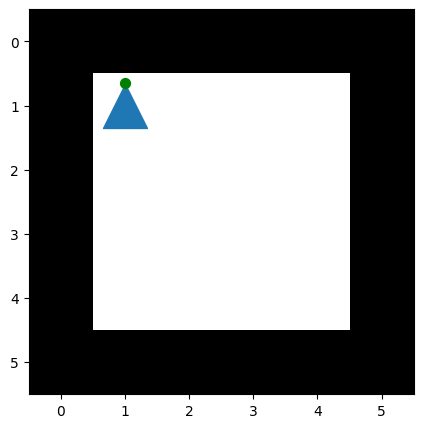

In [31]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
env_interaction.display_world()

In [32]:
list_vocab = ['<pad>', '<Masked>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))

list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))

for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)

tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)

<pad>
<Masked>
('forward', 'wall')
('forward', 'empty')
('turn_left', 'empty')
('turn_right', 'empty')
('feel_front', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')


In [33]:
def get_data_interaction(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        data.append(tokenizer.encode((action, feedback)))
    return data

In [34]:
data_train_inter = []
for i in range(10):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=5))
print("data_train_inter", data_train_inter)
for seq in data_train_inter:
    print(tokenizer_interaction.decode(seq))

data_train_inter [[8, 2, 2, 4, 10], [9, 2, 2, 2, 9], [5, 8, 6, 6, 8], [6, 4, 2, 2, 5], [11, 11, 8, 6, 2], [6, 5, 4, 2, 11], [11, 8, 8, 11, 2], [11, 6, 6, 11, 4], [4, 4, 3, 5, 9], [9, 11, 11, 5, 10]]
[('feel_left', 'wall'), ('forward', 'wall'), ('forward', 'wall'), ('turn_left', 'empty'), ('feel_right', 'wall')]
[('feel_left', 'empty'), ('forward', 'wall'), ('forward', 'wall'), ('forward', 'wall'), ('feel_left', 'empty')]
[('turn_right', 'empty'), ('feel_left', 'wall'), ('feel_front', 'wall'), ('feel_front', 'wall'), ('feel_left', 'wall')]
[('feel_front', 'wall'), ('turn_left', 'empty'), ('forward', 'wall'), ('forward', 'wall'), ('turn_right', 'empty')]
[('feel_right', 'empty'), ('feel_right', 'empty'), ('feel_left', 'wall'), ('feel_front', 'wall'), ('forward', 'wall')]
[('feel_front', 'wall'), ('turn_right', 'empty'), ('turn_left', 'empty'), ('forward', 'wall'), ('feel_right', 'empty')]
[('feel_right', 'empty'), ('feel_left', 'wall'), ('feel_left', 'wall'), ('feel_right', 'empty'), ('f

In [35]:
td = TokenDrop(0.5, pad_token=0, num_special=2)

data_target_inter = td(torch.tensor(data_train_inter))
print("data_target_inter", data_target_inter)

data_target_inter tensor([[ 0,  0,  0,  4,  0],
        [ 0,  0,  2,  0,  9],
        [ 5,  8,  6,  0,  0],
        [ 0,  4,  2,  2,  5],
        [ 0, 11,  8,  0,  2],
        [ 0,  0,  0,  0,  0],
        [11,  0,  0, 11,  2],
        [11,  6,  6, 11,  0],
        [ 4,  4,  3,  5,  9],
        [ 9, 11,  0,  5, 10]])


In [36]:
data_set_interaction = CustomDataSet(data_train_inter)

tensor([[ 8,  2,  2,  4, 10],
        [ 9,  2,  2,  2,  9],
        [ 5,  8,  6,  6,  8],
        [ 6,  4,  2,  2,  5],
        [11, 11,  8,  6,  2],
        [ 6,  5,  4,  2, 11],
        [11,  8,  8, 11,  2],
        [11,  6,  6, 11,  4],
        [ 4,  4,  3,  5,  9],
        [ 9, 11, 11,  5, 10]])


In [37]:
def train_inter(model: nn.Module, data_loader_train: DataLoader, nb_epoch: int, optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td = TokenDropOdd(pourcentTokenDrop, pad_token=0, num_special=2)

    model.train()
    list_acc = []
    list_loss = []
    for epoch in tqdm(range(nb_epoch), desc=f"Training ", unit="epoch"):
        acc_means = 0
        loss_means = 0
        
        for i, data in enumerate(data_loader_train):
            data_mask = td(data)
            bs = data.shape[0]

            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size)
                        
            proba, hidden, memory = model(data_mask, hidden, memory)
            proba = proba.transpose(1, 2)
            pred = proba.argmax(dim=1)
            pad_mask = (data_mask == 0)
            # print("data_mask", data_mask)
            # print("pad_mask", pad_mask)
            # print("pred", pred)
            # print("data", data)
            
            correct = (pred == data) & pad_mask
            # print("correct", correct)
            # print("pad_mask", pad_mask)
            acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
            acc_means += acc
        
            loss = loss_fn(proba, data) 
            loss_means += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        acc_means /= len(data_loader_train)
        loss_means /= len(data_loader_train)
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {epoch + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")

In [38]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

list_vocab = ['<pad>', '<Masked>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))    
tmp = create_dico_numerate_word(list_vocab)
tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)

data_train_inter = []
for i in range(500):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=5))
data_set_interaction = CustomDataSet(data_train_inter)
data_loader_interaction = DataLoader(data_set_interaction, batch_size=2, shuffle=True)

model_inter = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.25
)

optimizer_inter = optim.Adam(model_inter.parameters(), lr=0.001)
loss_fn_inter = nn.CrossEntropyLoss()

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
tensor([[ 2,  5,  8,  3, 11],
        [ 7, 11, 11,  7,  3],
        [ 4, 11, 11,  2,  5],
        ...,
        [ 5, 11,  8,  6, 11],
        [ 4, 10,  6,  9,  4],
        [10,  7, 10,  3,  5]])


In [39]:
# train_inter(
#     model=model_inter,
#     data_loader_train=data_loader_interaction,
#     nb_epoch=100,
#     optimizer=optimizer_inter,
#     loss_fn=loss_fn_inter,
#     pourcentTokenDrop=0.15
# )